# Adversarial example

__Author :__ Mithuran Gajendran

__Aim :__ Make a perturbation in an image that makes the network misclassify it

__Tools :__ We will be using VGG16 as a pretrained model and keras as a Deep Learning framework

### Imports

In [3]:
import numpy as np
import pandas as pd
from keras.applications import vgg16
from keras import backend as K
from keras.layers import Input
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from utils.preprocessing import format_img_vgg, unformat_image

In [4]:
colab = False

We loaded backend as K, it is a super cool feature that allows us to code without overly think about the undergoing process

# Introduction

Adversarial samples are modified images that makes the network misclassify it.
As seen in the article, there are different approach. In our case, we will use gradient maximisation approach (2.8). This consists in iteratively adding the gradient of the loss with respect to the image, to the current image, in order to get a misclassified image.

I will  try to keep it well explained !

# Let's begin !

## Preprocessing

First, let's load the vgg16 nn, and let's have a look to the parameters. We will need to get the last classification layer too , do not forget the include_top = True

In [5]:
model=vgg16.VGG16(weights='imagenet',include_top=True)
#create layer dictionary to easily name them
layer_dict = dict([ (layer.name,layer) for layer in model.layers])
#create backend Tensor
img_backend = model.input
# display architecture
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

I am pretty sure you have already used, or seen this network (thanks Monsieur Chollet). We are using the fully connected layers, so we have to format our input images to the correct input size [224,224]. You may use the following to load images:

In [6]:
if (colab == True):
    !wget "https://raw.githubusercontent.com/Blacklord100/Medium/master/Hackers-vs-Neural-Networks-Game-on/images/yann-cat.jpeg"
    img_in,img_visu = format_img_vgg('yann-cat.jpeg')
    plt.imshow(img_visu)
else:
    try:
        img_in,img_visu = format_img_vgg('image/yann-cat.jpeg')
    except:
        print('Data error: check your path')   
    else:
        pass

![Merci Yann pour ce si jolie chat](image/yann-cat.jpeg)

Thanks Yann for such a cute cat :)
Let's verify that vgg works !

In [7]:
# find the true class by predicting it
y_predicted = model.predict(img_in)

In [8]:
# print the prediction probability with their classes
y_predicted_decoded = vgg16.decode_predictions(y_predicted, top=5)[0]
pd.DataFrame(y_predicted_decoded)

,0,1,2
0,n02123045,tabby,0.415729
1,n02124075,Egyptian_cat,0.406226
2,n02123159,tiger_cat,0.148321
3,n04040759,radiator,0.007515
4,n02127052,lynx,0.005981


So it is definitely a tabby cat ! VGG confirmed :)

## Gradient ascent maximisation

To create our adversarial image, we have to modify an image categorized as A so that it maximises the response of our VGG network as class B at the prediction layer.

And that's easy ! Conceptually, it would be the opposite of a gradient descent with a class B biased loss.  In other words, we modify our image by adding iteratively the gradient of the average response of the class we want it to be ! 

A pseudo-code for this would be :

- img = img_in
- for i=1:n_iters
    - img = img + grad_step $\nabla_{img} \mathcal{L}$,
    
where $\mathcal{L}$ is the average response of the targeted class

Our goal is to transform this cat slighty to make it recognised as a banana (954). In other words, we have to maximize the features of bananas into the cat image. To do so, we will start by getting the prediction layer of the VGG model

In [9]:
target_class = 954

In [10]:
last_layer = layer_dict['predictions'].output
#create a function to get last layer of the VGG16 network
get_prediction_layer = K.function([img_backend],[last_layer])

How should we define the loss that we wish to maximise ? 

It is the average response of the targeted class of the predicition layer. To avoid image destruction or gradient update issues, we normalise the gradient.


In [11]:
loss_class = K.mean(last_layer[:,target_class])
grads_class = K.gradients(loss_class,img_backend)[0]

# normalize the gradient
grads_normalised_class = grads_class / (K.maximum(K.mean(K.abs(grads_class)), K.epsilon()))

# create function to retrieve loss and gradients of loss with respect to image
get_loss_and_grads_class = K.function([img_backend],[loss_class,grads_normalised_class])

We should reload the image, to make sure we are not starting from previous point.We included here different use cases:
* the cat image itself
* random noize
* Black image



In [16]:
# Select your image
img_in,_ = format_img_vgg('image/yann-cat.jpeg')
#img_in = 10*np.random.randn(1,img_in.shape[1],img_in.shape[2],img_in.shape[3])
#img_in = np.full((1,img_backend.shape[1],img_backend.shape[2],img_backend.shape[3]),0)

In [18]:
#parameters
step = 0.5  # Gradient ascent step size
n_iterations = 30  # Number of gradient ascent steps
for ii in range(0,n_iterations):
    
    loss_value,grads_value = get_loss_and_grads_class([img_in])
    img_in = img_in + step * grads_value 
    
    if (ii%5==0):
        img_show = unformat_image(np.copy(img_in))
        plt.imsave('image_dump/'+'img_out_'+str(target_class)+'_'+str(ii).zfill(3)+'.png',img_show)
        #predict current model to see evolution of top classification
        y_predicted = model.predict(img_in)
        print(vgg16.decode_predictions(y_predicted, top=1)[0])
        
print('---Adversarial attack completed !---')

[('n02123045', 'tabby', 0.4293026)]
[('n02123045', 'tabby', 0.4368989)]
[('n02123045', 'tabby', 0.4464773)]
[('n07753592', 'banana', 0.7014032)]
[('n07753592', 'banana', 0.9999939)]
[('n07753592', 'banana', 0.99999547)]
---Adversarial attack completed !---


[('n07753592', 'banana', 0.9999962), ('n03047690', 'clog', 1.1664309e-06), ('n01829413', 'hornbill', 3.9943896e-07), ('n07760859', 'custard_apple', 2.3102767e-07), ('n07753275', 'pineapple', 2.1976405e-07)]


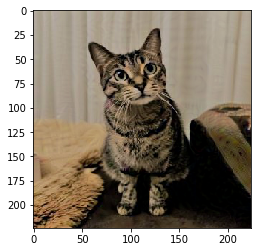

In [19]:
# finally, display the adversarial image
img_show = unformat_image(np.copy(img_in))
plt.imshow(img_show)
#show the prediction over the adversarial image
y_predicted = model.predict(img_in)
print(vgg16.decode_predictions(y_predicted, top=5)[0])

Incredible, the model has been fooled. Worse, the model doesn't recognise the cat in the top 5 predicitions

![LSD cat](image/strong_banana_cat.png)

Wow ! Some psychantropic images, go have a look at google deep dream project, uses the same method to get weird images. With  a higher stepsize, we can definitely see the bananas shape all over the cat !

I then took a picture of the cat with my phone, send it through WhatsApp (compression), and cropped it:

In [26]:
img_in,img_visu = format_img_vgg('image/banana-cat-picture-iphone-cropped.jpeg')

In [27]:
y_predicted = model.predict(img_in)
y_predicted_decoded = vgg16.decode_predictions(y_predicted, top=5)[0]
print(y_predicted_decoded)

[('n07753592', 'banana', 0.47698247), ('n02123045', 'tabby', 0.18972419), ('n02124075', 'Egyptian_cat', 0.15499581), ('n02123159', 'tiger_cat', 0.06426503), ('n03950228', 'pitcher', 0.008806198)]


![photo-of-the-banana-cat](image/banana-cat-picture-iphone-cropped.jpeg)

Damn it ! This is still a banana. By looking closely, you can see some banana pattern on the left

# Conclusion

My conclusion will be brief:
* this kind of adversariall images can have desastrous effects, think about a car misleading a stop sign with a 60 mph sign
* cheat on a compagnie's security log 
* use preprocessing to blur out "invisible defects" graDIENT FILTER ?